# Pythagorean Expectation and English Soccer

In soccer, teams score goals, and we can calculate Pythagorean Expectations based on goals scored and goals conceded.

The structure of competition in soccer in most countries around the world is different from the sports we have looked at so far. Rather than leagues operating as independent entities, they are connected through a hierarchical system, sometimes called "the pyramid". In England, the English Premier League is at the top of the pyramid (it used to be called the First Division) and contains 20 teams. 

Beneath the Premier League is The Football League Championship (it used to be called Division Two) and it contains 24 teams. The Premier League and the Championship are linked via the system of promotion and relegation. At the end of each season, the three worst performing teams (measured by points won in competition) are relegated to play Championship soccer in the following season, to be replaced by the three best performing teams in the Championship. Beneath the Championship are two more leagues - League One (formerly Third Division) and League Two (formerly Fourth Division). These leagues are also linked, hierarchically, through promotion and relegation. Thus it makes sense to think of these four divisions as part of a common system. 

In any one season, there are 92 teams in the system. Even though teams compete in different divisions, we can define both win percentage and Pythagorean Expectation for each team, in order to see how well the data fits.

In each of the four divisions, every team plays every other team twice in a season, once at home and once away. There is no playoff, so the champion is the team at the end of the season with the largest number of points (3 points for a win, one for a draw (tie)). Unlike the leagues we have looked at so far, draws are not only possible but are quite common. We need to adjust our definition of win percentage for this case. We could create a statistic such as the percentage of maximum possible points, but instead, we do something simpler- we give a value of 1 for a win, 0 for a loss, and 1/2 for a draw.

We now follow the same procedure we have used to date.

In [28]:
# Load the packages

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Load the data. 
# Our data covers the 2017/18 season
# We print out the list of variables names in the dataframe
file_path = r"D:\Sports Performance Analytics Specialization\Data\Week 1\Engsoccer2017-18.xlsx"
Eng18 = pd.read_excel(file_path, engine='openpyxl')
print(Eng18.columns.tolist())

['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']


In [30]:
# We can see what our dataframe looks like simply by typing its name

Eng18.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,EPL,2017-11-08 00:00:00,Arsenal,Leicester,4,3,H
1,EPL,2017-12-08 00:00:00,Brighton,Man City,0,2,A
2,EPL,2017-12-08 00:00:00,Chelsea,Burnley,2,3,A
3,EPL,2017-12-08 00:00:00,Crystal Palace,Huddersfield,0,3,A
4,EPL,2017-12-08 00:00:00,Everton,Stoke,1,0,H


In [31]:
# Once again our data is in the form of game results. We first identify whether the result was a win for the home team (H),
# the away team (A) or a draw (D). We also create the counting variable.

Eng18['hwinvalue']=np.where(Eng18['FTR']=='H',1,np.where(Eng18['FTR']=='D',.5,0))
Eng18['awinvalue']=np.where(Eng18['FTR']=='A',1,np.where(Eng18['FTR']=='D',.5,0))
Eng18['count']=1

In [32]:
Eng18.rename(columns={

    'Date': 'Match_Date',
    'HomeTeam': 'H_Team_Name',
    'AwayTeam': 'A_Team_Name',
    'FTHG': 'FT_Home_Goals',
    'FTAG': 'FT_Away_Goals',
    'FTR': 'FT_Result',
    'hwinvalue': 'H_Team_Wins',
    'awinvalue': 'A_Team_Wins',
    'count': 'Match_Count'
}, inplace=True)
Eng18.head()


,Div,Match_Date,H_Team_Name,A_Team_Name,FT_Home_Goals,FT_Away_Goals,FT_Result,H_Team_Wins,A_Team_Wins,Match_Count
0,EPL,2017-11-08 00:00:00,Arsenal,Leicester,4,3,H,1.0,0.0,1
1,EPL,2017-12-08 00:00:00,Brighton,Man City,0,2,A,0.0,1.0,1
2,EPL,2017-12-08 00:00:00,Chelsea,Burnley,2,3,A,0.0,1.0,1
3,EPL,2017-12-08 00:00:00,Crystal Palace,Huddersfield,0,3,A,0.0,1.0,1
4,EPL,2017-12-08 00:00:00,Everton,Stoke,1,0,H,1.0,0.0,1


In [36]:
# Once again we have to create separate dfs to calculate home team and away team performance.
# Here is the home team df, including only the variables we need.

Enghome = Eng18.groupby(['H_Team_Name','Div'])['Match_Count','H_Team_Wins', 'FT_Home_Goals','FT_Away_Goals'].sum().reset_index()
Enghome = Enghome.rename(columns={'H_Team_Name':'Team_Name'})
Enghome

c:\Users\Dell\anaconda3\envs\hands_on_ml_env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,Team_Name,Div,Match_Count,H_Team_Wins,FT_Home_Goals,FT_Away_Goals
0,AFC Wimbledon,FL1,23,11.0,25,30
1,Accrington,FL2,23,18.5,42,19
2,Arsenal,EPL,19,16.0,54,20
3,Aston Villa,FLCH,23,17.5,42,19
4,Barnet,FL2,23,11.0,24,25
...,...,...,...,...,...,...
87,West Ham,EPL,19,10.0,24,26
88,Wigan,FL1,23,17.0,37,11
89,Wolves,FLCH,23,18.5,47,18
90,Wycombe,FL2,23,14.5,43,35


In [35]:
# Now we create the mirror image df for the away team results.

Engaway = Eng18.groupby('A_Team_Name')['Match_Count','A_Team_Wins', 'FT_Home_Goals','FT_Away_Goals'].sum().reset_index()
Engaway = Engaway.rename(columns={'A_Team_Name':'Team_Name'})
Engaway
# Once again we have to create separate dfs to calculate home team and away team performance.
# Here is the home team df, including only the variables we needed

c:\Users\Dell\anaconda3\envs\hands_on_ml_env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Team_Name,Match_Count,A_Team_Wins,FT_Home_Goals,FT_Away_Goals
0,AFC Wimbledon,23,9.0,28,22
1,Accrington,23,13.5,27,34
2,Arsenal,19,6.0,31,20
3,Aston Villa,23,12.0,23,30
4,Barnet,23,6.0,40,22
...,...,...,...,...,...
87,West Ham,19,6.0,42,24
88,Wigan,23,17.5,18,52
89,Wolves,23,16.0,21,35
90,Wycombe,23,15.5,25,36


In [38]:
# Merge the home team and away team results

Eng18 = pd.merge(Enghome, Engaway, on = ['Team_Name'], suffixes=["H","A"])
Eng18

,Team_Name,Div,Match_CountH,H_Team_Wins,FT_Home_GoalsH,FT_Away_GoalsH,Match_CountA,A_Team_Wins,FT_Home_GoalsA,FT_Away_GoalsA
0,AFC Wimbledon,FL1,23,11.0,25,30,23,9.0,28,22
1,Accrington,FL2,23,18.5,42,19,23,13.5,27,34
2,Arsenal,EPL,19,16.0,54,20,19,6.0,31,20
3,Aston Villa,FLCH,23,17.5,42,19,23,12.0,23,30
4,Barnet,FL2,23,11.0,24,25,23,6.0,40,22
...,...,...,...,...,...,...,...,...,...,...
87,West Ham,EPL,19,10.0,24,26,19,6.0,42,24
88,Wigan,FL1,23,17.0,37,11,23,17.5,18,52
89,Wolves,FLCH,23,18.5,47,18,23,16.0,21,35
90,Wycombe,FL2,23,14.5,43,35,23,15.5,25,36


In [39]:
# Sum the results by home and away measures to get the team overall performance for the season
Eng18['Total_Wins'] = Eng18['H_Team_Wins'] + Eng18['A_Team_Wins']  # Total Wins
Eng18['Total_Matches'] = Eng18['Match_CountH'] + Eng18['Match_CountA']  # Total Matches Played (Home + Away)
Eng18['Goals_Scored'] = Eng18['FT_Home_GoalsH'] + Eng18['FT_Away_GoalsA']  # Total Goals For (Home + Away)
Eng18['Goals_Conceded'] = Eng18['FT_Away_GoalsH'] + Eng18['FT_Home_GoalsA']  # Total Goals Against (Home + Away)
 
Eng18


,Team_Name,Div,Match_CountH,H_Team_Wins,FT_Home_GoalsH,FT_Away_GoalsH,Match_CountA,A_Team_Wins,FT_Home_GoalsA,FT_Away_GoalsA,Total_Wins,Total_Matches,Goals_Scored,Goals_Conceded
0,AFC Wimbledon,FL1,23,11.0,25,30,23,9.0,28,22,20.0,46,47,58
1,Accrington,FL2,23,18.5,42,19,23,13.5,27,34,32.0,46,76,46
2,Arsenal,EPL,19,16.0,54,20,19,6.0,31,20,22.0,38,74,51
3,Aston Villa,FLCH,23,17.5,42,19,23,12.0,23,30,29.5,46,72,42
4,Barnet,FL2,23,11.0,24,25,23,6.0,40,22,17.0,46,46,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,West Ham,EPL,19,10.0,24,26,19,6.0,42,24,16.0,38,48,68
88,Wigan,FL1,23,17.0,37,11,23,17.5,18,52,34.5,46,89,29
89,Wolves,FLCH,23,18.5,47,18,23,16.0,21,35,34.5,46,82,39
90,Wycombe,FL2,23,14.5,43,35,23,15.5,25,36,30.0,46,79,60


In [40]:
# Calculate the winning percentage (wpc)
Eng18['Winning_Percentage'] = Eng18['Total_Wins'] / Eng18['Total_Matches']

# Calculate the Pythagorean Expectation (pyth)
Eng18['Pythagorean_Expectation'] = Eng18['Goals_Scored']**2 / (Eng18['Goals_Scored']**2 + Eng18['Goals_Conceded']**2)
 
Eng18


,Team_Name,Div,Match_CountH,H_Team_Wins,FT_Home_GoalsH,FT_Away_GoalsH,Match_CountA,A_Team_Wins,FT_Home_GoalsA,FT_Away_GoalsA,Total_Wins,Total_Matches,Goals_Scored,Goals_Conceded,Winning_Percentage,Pythagorean_Expectation
0,AFC Wimbledon,FL1,23,11.0,25,30,23,9.0,28,22,20.0,46,47,58,0.434783,0.396375
1,Accrington,FL2,23,18.5,42,19,23,13.5,27,34,32.0,46,76,46,0.695652,0.731880
2,Arsenal,EPL,19,16.0,54,20,19,6.0,31,20,22.0,38,74,51,0.578947,0.677974
3,Aston Villa,FLCH,23,17.5,42,19,23,12.0,23,30,29.5,46,72,42,0.641304,0.746114
4,Barnet,FL2,23,11.0,24,25,23,6.0,40,22,17.0,46,46,65,0.369565,0.333701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,West Ham,EPL,19,10.0,24,26,19,6.0,42,24,16.0,38,48,68,0.421053,0.332564
88,Wigan,FL1,23,17.0,37,11,23,17.5,18,52,34.5,46,89,29,0.750000,0.904017
89,Wolves,FLCH,23,18.5,47,18,23,16.0,21,35,34.5,46,82,39,0.750000,0.815525
90,Wycombe,FL2,23,14.5,43,35,23,15.5,25,36,30.0,46,79,60,0.652174,0.634184


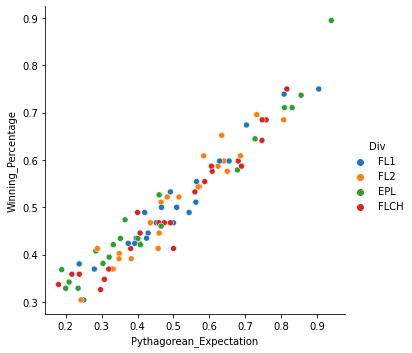

In [41]:
# Plot the data
# Seaborn allow us to color code teams based on division

sns.relplot(x="Pythagorean_Expectation", y="Winning_Percentage", data =Eng18,hue='Div')

## Self test

run sns.relplot again, but this time write y="W" instead of y="wpc". What do you find? Does it make a difference?

In [42]:
# Run the regression

pyth_lm = smf.ols(formula = 'Winning_Percentage ~ Pythagorean_Expectation', data=Eng18).fit()
pyth_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Winning_Percentage   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1265.
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           8.87e-55
Time:                        12:30:06   Log-Likelihood:                 187.39
No. Observations:                  92   AIC:                            -370.8
Df Residuals:                      90   BIC:                            -365.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1803      0.010     18.804      0.000       0.161       0.199
Pythagorean_Expectation     0.6502      0.018     35.561      0.000       0.614       0.687
==============================================================================
Omnibus:                        3.561   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                2.898
Skew:                           0.327   Prob(JB):                        0.235
Kurtosis:                       3.574   Cond. No.                         6.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Self test

Run the regression above but instead write 'wpc ~ result' instead of 'wpc ~ result' in the line starting pyth_lm. What difference does this make?

# Conclusion

Notwithstanding the different organizational structures of soccer, we have found the Pythagorean Expectation model fits the data well.

We have now looked at league results from four different sports and found that the Pythagorean model fits the data well in three of the four. 

But we now want to consider a different question: does the Pythagorean model work as a forecasting model? We address this question in the next notebook. 


